In [2]:
!pip install scikit-learn



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import joblib
import os

plt.rcParams["figure.figsize"] = (8, 6)

# make sure folders exist (they'll be created next to this notebook)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("figures", exist_ok=True)



In [7]:
data_path = "data.csv"
df = pd.read_csv(data_path)

df.head()


,state_fips,county_fips,county_state,Year,unemployment_rate,full_fips,sanctuary_status
0,1.0,1.0,"Autauga County, AL",2024.0,2.7,1001,0
1,1.0,3.0,"Baldwin County, AL",2024.0,2.7,1003,0
2,1.0,5.0,"Barbour County, AL",2024.0,4.3,1005,0
3,1.0,7.0,"Bibb County, AL",2024.0,3.0,1007,0
4,1.0,9.0,"Blount County, AL",2024.0,2.7,1009,0


In [8]:
# set the target column
target_col = "unemployment_rate"

# drop rows where unemployment is missing
df = df.dropna(subset=[target_col])

# select only numeric columns as candidates for features
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# features = all numeric columns except the target
feature_cols = [c for c in numeric_cols if c != target_col]

X = df[feature_cols]
y = df[target_col]

print("Number of features:", len(feature_cols))
print("Feature columns:", feature_cols[:10], "...")
X.head()


Number of features: 5
Feature columns: ['state_fips', 'county_fips', 'Year', 'full_fips', 'sanctuary_status'] ...


,state_fips,county_fips,Year,full_fips,sanctuary_status
0,1.0,1.0,2024.0,1001,0
1,1.0,3.0,2024.0,1003,0
2,1.0,5.0,2024.0,1005,0
3,1.0,7.0,2024.0,1007,0
4,1.0,9.0,2024.0,1009,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((2576, 5), (645, 5))

In [11]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)

# First compute MSE, then take square root for RMSE
mse_base = mean_squared_error(y_test, y_pred_base)
rmse_base = mse_base ** 0.5

r2_base = r2_score(y_test, y_pred_base)

print("Baseline MAE:", mae_base)
print("Baseline RMSE:", rmse_base)
print("Baseline R^2:", r2_base)



Baseline MAE: 0.9685945399393326
Baseline RMSE: 1.3794182927954677
Baseline R^2: -0.00030208037167755997


In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5

r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R^2:", r2_lr)


Linear Regression MAE: 0.9657071520665462
Linear Regression RMSE: 1.378452027707167
Linear Regression R^2: 0.001098826739077241


In [13]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R^2:", r2_rf)


Random Forest MAE: 0.8388992248062016
Random Forest RMSE: 1.2010736343762598
Random Forest R^2: 0.24163465784184046


In [14]:
joblib.dump(baseline, "models/baseline_dummy_regressor.joblib")
joblib.dump(lin_reg, "models/linear_regression.joblib")
joblib.dump(rf, "models/random_forest_regressor.joblib")


['models/random_forest_regressor.joblib']

In [15]:
import pandas as pd

metrics = [
    {"model": "baseline_dummy", "MAE": mae_base, "RMSE": rmse_base, "R2": r2_base},
    {"model": "linear_regression", "MAE": mae_lr, "RMSE": rmse_lr, "R2": r2_lr},
    {"model": "random_forest", "MAE": mae_rf, "RMSE": rmse_rf, "R2": r2_rf}
]

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("results/model_comparison_metrics.csv", index=False)

metrics_df


,model,MAE,RMSE,R2
0,baseline_dummy,0.968595,1.379418,-0.000302
1,linear_regression,0.965707,1.378452,0.001099
2,random_forest,0.838899,1.201074,0.241635


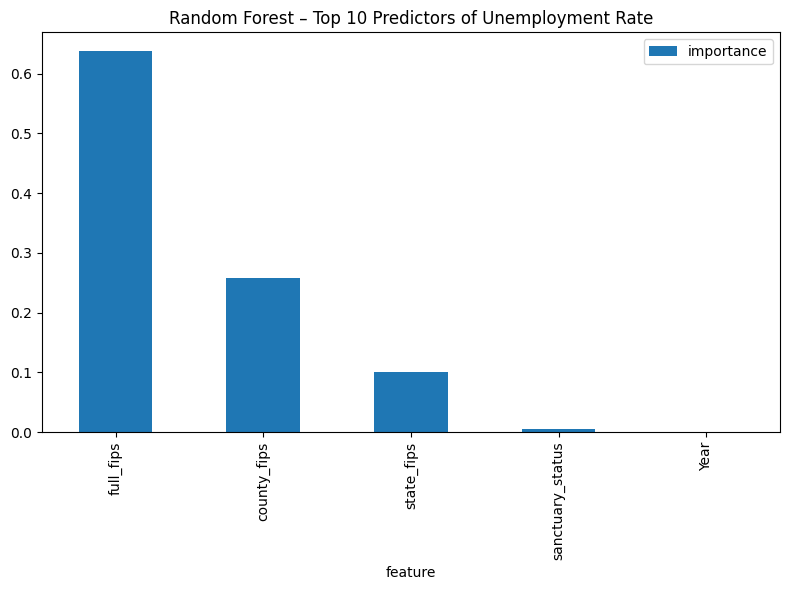

In [16]:
importances = rf.feature_importances_
feat_names = X.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

fi.plot(kind="bar", x="feature", y="importance")
plt.title("Random Forest – Top 10 Predictors of Unemployment Rate")
plt.tight_layout()
plt.savefig("figures/rf_feature_importance_top10.png", dpi=300)
plt.show()


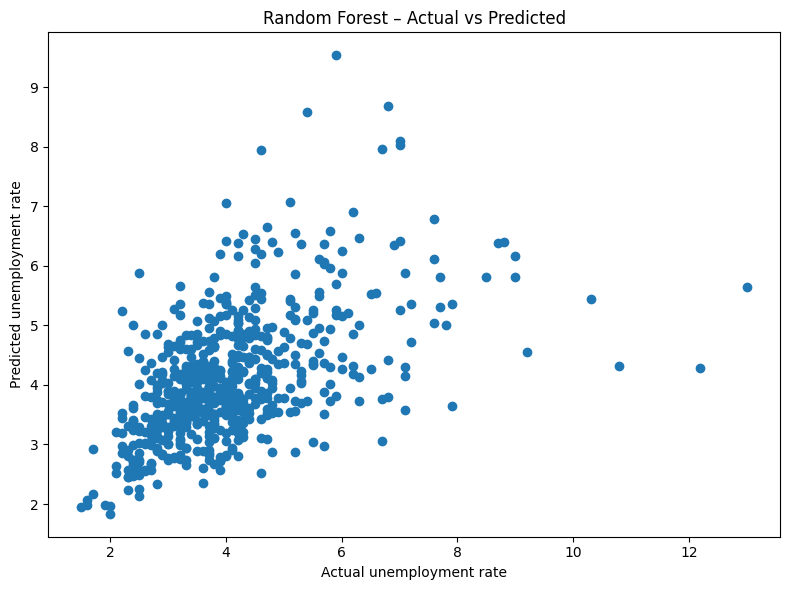

In [17]:
plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual unemployment rate")
plt.ylabel("Predicted unemployment rate")
plt.title("Random Forest – Actual vs Predicted")
plt.tight_layout()
plt.savefig("figures/rf_actual_vs_predicted.png", dpi=300)
plt.show()


In [18]:
print("Models:", os.listdir("models"))
print("Results:", os.listdir("results"))
print("Figures:", os.listdir("figures"))


Models: ['random_forest_regressor.joblib', 'baseline_dummy_regressor.joblib', 'linear_regression.joblib']
Results: ['model_comparison_metrics.csv']
Figures: ['rf_actual_vs_predicted.png', 'rf_feature_importance_top10.png']
